In [3]:
import numpy as np
import pandas as pd
import operator as op

# Load the NPZ dataset
dataset = np.load('data/tlol/npz_short_data_0.npz')
dataset

NpzFile 'data/tlol/npz_short_data_0.npz' with keys: classes, centerpoints, timestamps, healths, gameIds...

In [4]:
import numpy as np

# Get the required data from the dataset
gameIds = dataset["gameIds"] # Note: this is a byte array, not a float
# Replace gameIds with a unique integer for each game
allGameIds = np.unique(dataset["gameIds"])
gameIdsAsInts = np.arange(len(allGameIds))
gameIdMap = dict(zip(allGameIds, gameIdsAsInts))
gameIds = np.array(list(map(lambda x: gameIdMap[x], gameIds)))
teamIds = dataset["teamIds"]
classes = dataset["classes"]
timestamps = np.round(dataset["timestamps"], 1).astype(np.float32)
centerpoints = dataset["centerpoints"]
healths = dataset["healths"]

# Form a matrix of the required data
data = np.column_stack((gameIds, teamIds, classes, timestamps, centerpoints, healths))

In [5]:

filtered_rows = data[(data[:, 0] == 0) & (data[:, 1] == 100)]
filtered_rows


array([[0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       [0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       [0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       ...,
       [0.0000000e+00, 1.0000000e+02, 4.0000000e+00, ..., 1.5504756e+03,
        1.1156224e+04, 6.5203610e+02],
       [0.0000000e+00, 1.0000000e+02, 4.0000000e+00, ..., 1.4719806e+03,
        1.1121208e+04, 6.5282570e+02],
       [0.0000000e+00, 1.0000000e+02, 4.0000000e+00, ..., 1.5504783e+03,
        1.1096238e+04, 6.5282570e+02]])

In [6]:
filters = [
    [
        [3, op.gt, 7.5],
        [0, op.eq, 0]
    ]
]

parse_filter = lambda filter, data_to_filter: filter[1](data_to_filter[:, filter[0]], filter[2])


def get_column_filters(data_to_filter, filters_to_use):
    return [[parse_filter(filter, data_to_filter) for filter in filter_group] for filter_group in filters_to_use]


def filter_with_rules(data_to_filter, rules):
    mask = np.any([np.all(column_filter_group, axis=0) for column_filter_group in rules], axis=0)
    return data_to_filter[mask]

print(get_column_filters(data, filters))

matching_rows = filter_with_rules(data, get_column_filters(data, filters))

matching_rows

[[array([False, False, False, ...,  True,  True,  True]), array([ True,  True,  True, ..., False, False, False])]]


array([[0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       [0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       [0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       ...,
       [0.0000000e+00, 2.0000000e+02, 9.0000000e+00, ..., 1.9186270e+03,
        1.2347886e+04, 6.2119660e+02],
       [0.0000000e+00, 2.0000000e+02, 9.0000000e+00, ..., 1.8403383e+03,
        1.2331019e+04, 6.2178620e+02],
       [0.0000000e+00, 2.0000000e+02, 9.0000000e+00, ..., 1.8403383e+03,
        1.2331019e+04, 6.2178620e+02]])

In [7]:
from collections import defaultdict

entries = defaultdict(list)
for game in gameIdsAsInts[:5]:
    gameRows = data[data[:, 0] == game]
    for timestamp in np.unique(gameRows[:, 3]):
        timestampRows = gameRows[gameRows[:, 3] == timestamp]
        team = 100 #200
        teamRows = timestampRows[timestampRows[:, 1] == team]
        enemyRows = timestampRows[timestampRows[:, 1] != team]
        entry = np.concatenate((teamRows[:, 4:6].flatten(), enemyRows[:, 4:6].flatten()))
        entries[game].append(entry)


entries.keys()

dict_keys([0, 1, 2, 3, 4])

In [8]:
df = pd.DataFrame(entries.values()).T
df

0  \
0    [612.0, 604.0, 436.0, 786.0, 136.0, 364.0, 402...   
1    [612.0, 604.0, 436.0, 786.0, 277.79147, 522.26...   
2    [612.0, 604.0, 401.88556, 646.6343, 344.98505,...   
3    [612.0, 604.0, 431.2839, 641.8046, 510.4234, 7...   
4    [612.0, 604.0, 420.449, 741.91693, 522.0, 772....   
..                                                 ...   
605  [13215.13, 3220.109, 7526.3213, 4916.0454, 738...   
606  [13215.13, 3220.109, 7509.483, 4832.654, 7352....   
607  [13264.32, 3288.4094, 7488.371, 4749.0273, 730...   
608  [13317.334, 3351.6865, 7467.0474, 4666.7314, 7...   
609  [13356.846, 3420.227, 7445.897, 4588.0493, 728...   

                                                     1  \
0    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 398...   
1    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 471...   
2    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 580...   
3    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 580...   
4    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 580...   
..                                                 ...   
605                                               None   
606                                               None   
607                                               None   
608                                               None   
609                                               None   

                                                     2  \
0    [402.0, 132.0, 286.0, 664.0, 612.0, 604.0, 136...   
1    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 136...   
2    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 136...   
3    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 273...   
4    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 343...   
..                                                 ...   
605  [2882.0881, 12526.021, 5134.2617, 7343.9854, 1...   
606  [2932.2288, 12462.088, 5134.2617, 7343.9854, 1...   
607  [2866.128, 12427.558, 5134.2617, 7343.9854, 10...   
608  [2790.1147, 12398.859, 5134.2617, 7343.9854, 1...   
609                                               None   

                                                     3  \
0    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 136...   
1    [402.0, 132.0, 468.0, 418.0, 286.0, 664.0, 136...   
2    [402.0, 132.0, 468.0, 418.0, 286.0, 664.0, 136...   
3    [402.0, 132.0, 420.0, 402.0, 286.0, 664.0, 136...   
4    [402.0, 132.0, 332.0, 396.0, 286.0, 664.0, 136...   
..                                                 ...   
605                                               None   
606                                               None   
607                                               None   
608                                               None   
609                                               None   

                                                     4  
0    [286.0, 664.0, 564.053, 180.72182, 311.92914, ...  
1    [286.0, 664.0, 708.0, 224.0, 511.1429, 444.269...  
2    [286.0, 664.0, 708.0, 224.0, 439.00494, 471.73...  
3    [286.0, 664.0, 708.0, 224.0, 375.7357, 385.763...  
4    [286.0, 664.0, 708.0, 224.0, 505.51776, 390.24...  
..                                                 ...  
605                                               None  
606                                               None  
607                                               None  
608                                               None  
609                                               None  

[610 rows x 5 columns]

In [9]:
a_single_player_single_game = [ row[0:2] for row in df[0]]
all_players_all_games = [ row.tolist()[i:i+2] for j in range(5) for row in df[j] if row is not None for i in range(0, 10, 2)]

In [10]:
all_players_all_games

[[612.0, 604.0],
 [436.0, 786.0],
 [136.0, 364.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [436.0, 786.0],
 [277.79147, 522.26105],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [401.88556, 646.6343],
 [344.98505, 638.41986],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [431.2839, 641.8046],
 [510.4234, 762.9884],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [420.449, 741.91693],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [265.23108, 635.57733],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [250.0, 624.0],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [250.0, 624.0],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [250.0, 624.0],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [250.0, 624.0],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],
 [250.0, 624.0],
 [522.0, 772.0],
 [402.0, 132.0],
 [676.0, 298.0],
 [612.0, 604.0],

In [11]:
def create_sequences(data, H, T):
    X, y = [], []
    for i in range(len(data) - H - T + 1):
        if i+H+T < len(data):
            X.append(data[i:i+H])  # Input sequence of length H
            y.append(data[i+H+T])  # Target sequence of length T
    return np.array(X), np.array(y)

X, y = create_sequences(a_single_player_single_game, 3, 1)

In [12]:
y

array([[  612.    ,   604.    ],
       [  612.    ,   604.    ],
       [  612.    ,   604.    ],
       ...,
       [13264.32  ,  3288.4094],
       [13317.334 ,  3351.6865],
       [13356.846 ,  3420.227 ]])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
def split_data(X, y):
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42, shuffle=False)
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the input sequences
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, X_test, y_train, y_test, idx_train, idx_test

def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, rmse, r2

# Define the window size H and prediction horizon T
H = 10  # Number of previous steps to consider
T = 1   # Number of future steps to predict

# Create sequences
X, y = create_sequences(a_single_player_single_game, H, T)

# Split the data into training and test sets
X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(X, y)

# Train the model
model = train_model(X_train, y_train)

# Evaluate the model
y_pred, mse, rmse, r2 = evaluate_model(model, X_test, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 8786.04972945783
Root Mean Squared Error: 92.51881536345769
R-squared: 0.8547412877986547


c:\Users\juppi\Documents\Koodit\lol-movement-ml\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


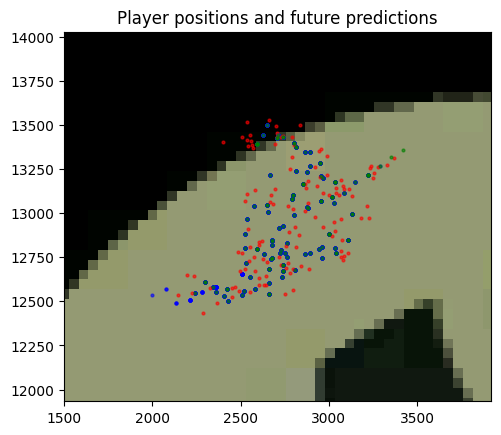

In [31]:
from numpy import single
from utils.compute_zoom_limits import compute_zoom_limits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_prediction_on_plot(plot, points, prediction, truth, map_image_path, zoom_range, options={}):
    """
    Plot the player positions on the map, and overlay the predicted and true future positions.

    Args:
    plot (matplotlib.pyplot): The plot to display the map on (can be a subplot or the main plot
    points (np.array): The player positions (x, y) at each time step
    prediction (np.array): The predicted future player positions (x, y)
    truth (np.array): The true future player positions (x, y)
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
    """

    # Get the options
    figsize = options.get('figsize', (10, 10))
    title = options.get('title', 'Player positions and future predictions')
    inputPointsSize = options.get('inputPointsSize', 2)
    predictionPointsSize = options.get('predictionPointsSize', 2)
    truthPointsSize = options.get('truthPointsSize', 2)
    inputPointsColor = options.get('inputPointsColor', 'blue')
    predictionPointsColor = options.get('predictionPointsColor', 'red')
    truthPointsColor = options.get('truthPointsColor', 'green')
    padding = options.get('padding', 500)

    # If plot is a subplot, clear
    if hasattr(plot, 'clear'):
        plot.clear()

    map_img = mpimg.imread(map_image_path)

    # Display image scaled to the variable
    plot.imshow(map_img, extent=[zoom_range[0][0], zoom_range[0][1], zoom_range[1][0], zoom_range[1][1]])

    # Overlay the player positions on the map
    for player_sequence in points:
        for i in range(1, len(player_sequence), 2):
            plot.plot(player_sequence[i], player_sequence[i-1], markersize=inputPointsSize, alpha=0.6, color=inputPointsColor, marker='o')

    for player in prediction:
        plot.plot(player[1], player[0], markersize=predictionPointsSize, alpha=0.6, color=predictionPointsColor, marker='o')

    for player in truth:
        plot.plot(player[1], player[0], markersize=truthPointsSize, alpha=0.6, color=truthPointsColor, marker='o')

    point_sequence_as_points = np.array([(point_sequence[i-1], point_sequence[i]) for point_sequence in points for i in range(1, len(point_sequence), 2)])

    all_points = np.concatenate((point_sequence_as_points, prediction, truth))
    # Zoom in to the center of the points
    smallest_y = np.min(all_points[:, 0])
    largest_y = np.max(all_points[:, 0])
    smallest_x = np.min(all_points[:, 1])
    largest_x = np.max(all_points[:, 1])
    
    # Set the limits of the plot differently for plot and subplot
    if hasattr(plot, 'gca'):
        plot = plot.gca()
    
    plot.set_xlim(smallest_x - padding, largest_x + padding)
    plot.set_ylim(smallest_y - padding, largest_y + padding)
    plot.set_title(title)

map_image_path = "assets/2x_2dlevelminimap.png"

# zoom_range = compute_zoom_limits(all_players_all_games, 0)
# print(zoom_range)
zoom_range = ((75, 14350), (75, 14350)) 

i = slice(0, 1000000)
plot_prediction_on_plot(plt, X_test[i], y_pred[i], y_test[i], map_image_path, zoom_range)

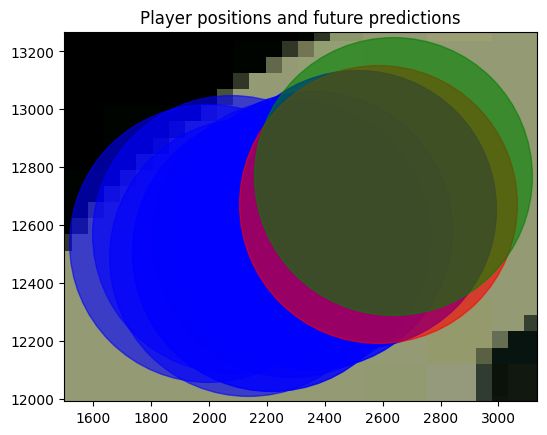

In [37]:
# Show the first 5 predictions in an animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def create_prediction_animation(points, prediction, truth, map_image_path, zoom_range, options={}):
    """
    Create an animation of the player positions and future predictions on the map.

    Args:
    points (np.array): The player positions (x, y) at each time step
    prediction (np.array): The predicted future player positions (x, y)
    truth (np.array): The true future player positions (x, y)
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
        - speed (int): The speed of the animation
    """
    fig, ax = plt.subplots()

    def update(frame):
        i = slice(frame, frame+1)
        ax.clear()
        plot_prediction_on_plot(ax, points[i], prediction[i], truth[i], map_image_path, zoom_range, options)        
    # Variable to control animation speed
    speed = options.get('speed', 1000)

    ani = FuncAnimation(fig, update, frames=range(len(X_test)), interval=speed, blit=False)
    return HTML(ani.to_jshtml())

options = {
    'speed': 1000,
    'predictionPointsSize': 200,
    'truthPointsSize': 200,
    'inputPointsSize': 200,
}

create_prediction_animation(X_test, y_pred, y_test, map_image_path, zoom_range, options)

